# import libraries

In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import ast
import random
import matplotlib.pyplot as plt

from torch.distributions import MultivariateNormal
from IPython.display import clear_output
import scipy.ndimage as ndimage
import os
import cv2
from torch.utils.data import DataLoader, Dataset
import metrics
import joblib
import copy
from torchvision import transforms
from enum import Enum
import faiss

from dataloaders import dataloader_MVTec_setup
from utils import get_files_masks, evaluate
from evaluate import load_model, visualize_result
from data import featuresExtractor
from DQN import DQN
from environment import Environment
import tqdm

# Arguments parse

In [2]:
def parse_tuple(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        raise argparse.ArgumentTypeError(f"Invalid tuple: {value}")
parser = argparse.ArgumentParser()
# ------------ 
# setup
# ------------
parser.add_argument("--use_gpu", action="store_true", help="Use GPU for training")
#parser.add_argument("--data_root", type=str, default= "./../../../../scratch-beauty/zzhan762/data/MVTec_AD")
#parser.add_argument("--data_root", type=str, default= "./mvtec")
parser.add_argument("--data_root", type=str, default= "./data/BraTS2D")
parser.add_argument("--verbose", type=bool, default=True)
# ------------------ 
# feature extractor
# ------------------
parser.add_argument("--target_size", type=parse_tuple, default="(192,192)")
parser.add_argument("--resize_size", type=parse_tuple, default="(192,192)")
parser.add_argument("--class_name", type=str, default="brats")
parser.add_argument("--batch_size", type=int, default=8)
parser.add_argument("--patch_size",type=int, default=3)
parser.add_argument("--target_embed_dimension", type=int, default=512)
parser.add_argument("--edc", action="store_true")
parser.add_argument("--backbone", type=str,default="wide_resnet50_2")
parser.add_argument("--preprocessing_dimension", type=int, default=512)

# ------------
# DQN 
# ------------
parser.add_argument("--action_dim", type=int, default=2)
parser.add_argument("--max_steps",type=int, default=int(5e4))
parser.add_argument("--eval_interval", type=int, default =int(1e3))
parser.add_argument("--lr",type=float,default = 0.00025)
parser.add_argument("--epsilon",type=float,default=1.0)
parser.add_argument("--epsilon_min",type=float,default=0.1)
parser.add_argument("--gamma", type=float, default=0.99)
parser.add_argument("--dqn_batch_size",type=int,default=32)
parser.add_argument("--warmup_steps",type=int, default=int(2e3))
parser.add_argument("--buffer_size",type=int,default=int(1e4))
parser.add_argument("--target_update_interval",type=int,default=int(5e3))

# ---------------
# Envirnment
# ---------------
parser.add_argument("--prob", type=float, default=0.5)
parser.add_argument("--max_samples",type=float,default=80)
parser.add_argument("--iForest_update_interval",type=int,default=int(2e3))
parser.add_argument("--iForest_max_samples",type=float,default=0.3)
parser.add_argument("--iForest_total_samples",type=int,default=int(1e6))
parser.add_argument("--iForest_batch_size",type=int,default=1024)


# -----------------------
# components
# -----------------------
parser.add_argument("--use_prioritized", type=bool, default=False)
parser.add_argument("--use_intrinsic",type=bool, default=False)
parser.add_argument("--use_copypaste", type=bool, default=False)
parser.add_argument("--use_faiss", type=bool, default=False)


args = parser.parse_args(['--use_gpu'])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() and args.use_gpu else "cpu")
print('device: {}'.format(device))
args.layers = ['layer2', 'layer3']
args.hidden_sizes = [256,128]
args.state_dim = args.target_embed_dimension

device: cuda


In [4]:
import re
def extract_numbers(filename):
    # This regex captures two groups of digits separated by non-digit characters
    match = re.findall(r'\d+', filename)
    if match and len(match) >= 3:
        return (int(match[1]), int(match[2]))  # Return a tuple of two integers
    return (0, 0)
def get_brats_files(data_root,n, verbose=False):
    featureExtractor = featuresExtractor([],args,device)

    train_path = os.path.join(data_root,'train','images')
    val_path = os.path.join(data_root,'val','images')
    val_mask_path = os.path.join(data_root,'val','masks')
    test_path = os.path.join(data_root,'test','images')
    test_mask_path = os.path.join(data_root,'test','masks')
    '''
    train_files = [os.path.join(train_path, x) for x in sorted(os.listdir(train_path))]
    val_files = [os.path.join(val_path, x) for x in sorted(os.listdir(val_path))]
    val_masks = [os.path.join(val_mask_path, x) for x in sorted(os.listdir(val_mask_path))]
    test_files = [os.path.join(test_path, x) for x in sorted(os.listdir(test_path))]
    test_masks = [os.path.join(test_mask_path, x) for x in sorted(os.listdir(test_mask_path))]
    '''
    train_files = [os.path.join(train_path, x) for x in sorted(os.listdir(train_path), key=extract_numbers)]
    val_files = [os.path.join(val_path, x) for x in sorted(os.listdir(val_path), key=extract_numbers)]
    val_masks = [os.path.join(val_mask_path, x) for x in sorted(os.listdir(val_mask_path), key=extract_numbers)]
    test_files = [os.path.join(test_path, x) for x in sorted(os.listdir(test_path), key=extract_numbers)]
    test_masks = [os.path.join(test_mask_path, x) for x in sorted(os.listdir(test_mask_path), key=extract_numbers)]


    random.seed(42)
    #idxs =  random.sample(list(range(len(val_files))),n)
    #train_abnormal_files = [val_files[i] for i in idxs]
    #train_abnormal_masks = [val_masks[i] for i in idxs]
    
    indexes = random.sample(list(range(len(val_files))),len(val_files))

    idxs = []
    i=0
    while len(idxs) < n:
        _,_,masks = featureExtractor.get_features(val_files[indexes[i]:indexes[i]+1],val_masks[indexes[i]:indexes[i]+1])
        if masks.max() == 1:
            idxs.append(indexes[i])
        i+=1
    train_abnormal_files = [val_files[i] for i in idxs]
    train_abnormal_masks = [val_masks[i] for i in idxs]
    val_files = [elem for idx, elem in enumerate(val_files) if idx not in idxs]
    val_masks = [elem for idx, elem in enumerate(val_masks) if idx not in idxs]

    
    files_dict = {
        'train_normal_files': train_files,
        'train_target_files': train_abnormal_files,
        'train_target_masks': train_abnormal_masks,
        'val_files': val_files,
        'val_masks': val_masks,
        'test_files': test_files,
        'test_masks': test_masks
    }
    if verbose:
        for item, value in files_dict.items():
            print("{}: {}".format(item, len(value)))
    return files_dict

In [5]:
files_dict = get_brats_files(args.data_root,10,verbose=True)
print(files_dict['test_masks'][-7])
print(files_dict['test_masks'][-6])

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])
train_normal_files: 55488
train_target_files: 10
train_target_masks: 10
val_files: 24086
val_masks: 24086
test_files: 96000
test_masks: 96000
./data/BraTS2D\test\masks\BraTS2021_01666_89.png
./data/BraTS2D\test\masks\BraTS2021_01666_90.png


In [8]:
def get_brats_scores(checkpoint_path,device):
    agent, args, files_dict = load_model(checkpoint_path)

    files_dict = get_brats_files(args.data_root,10,verbose=True)
    unknown_imgs = []
    unknown_scores =[]
    unknown_labels = []
    feature_extractor = featuresExtractor(files_dict['train_normal_files'],args, device)

    for file, mask_file in tqdm.tqdm(zip(files_dict['test_files'][71904:],files_dict['test_masks'][71904:])):
        images,embeds,mask = feature_extractor.get_features([file],[mask_file])
        images = images.squeeze().cpu().numpy()
        mask = mask.squeeze()
        mask = mask > 0.5
        
        embeds = torch.from_numpy(embeds.squeeze()).to(device)
        H,W,dim = embeds.shape
        embeds = embeds.reshape(-1,dim)
        score = agent.network(embeds)
        score_sum = torch.sum(score,dim=1)
        score = score/score_sum.view(-1,1)
        score = score[:,1]
        
        score = score.reshape(H,W).detach().cpu().numpy()
        unknown_imgs.append(images)
        unknown_scores.append(score)
        unknown_labels.append(mask)
    unknown_imgs = np.array(unknown_imgs)
    unknown_scores = np.array(unknown_scores)
    unknown_labels = np.array(unknown_labels)
    scores_dict = {
        "total_scores": unknown_scores,
        "total_labels": unknown_labels,
        "total_imgs": unknown_imgs
    }
    return scores_dict


In [7]:

def evaluate_brats_metrics(checkpoint_path,device):
    agent, args, files_dict = load_model(checkpoint_path)

    #files_dict = get_brats_files(args.data_root,10,verbose=True)
    unknown_scores =[]
    unknown_labels = []
    feature_extractor = featuresExtractor(files_dict['train_normal_files'],args, device)
    paurocs = []
    ppros=[]
    pdices = []
    Ilabels = []
    Iscores = []
    #for i, (file, mask_file) in tqdm.tqdm(enumerate(zip(files_dict['val_files'][:4800],files_dict['val_masks'][:4800]))):
    for i, (file, mask_file) in tqdm.tqdm(enumerate(zip(files_dict['test_files'],files_dict['test_masks']))):
        images,embeds,mask = feature_extractor.get_features([file],[mask_file])
        images = images.squeeze().cpu().numpy()
        mask = mask.squeeze()
        mask = mask > 0
        
        embeds = torch.from_numpy(embeds.squeeze()).to(device)
        H,W,dim = embeds.shape
        embeds = embeds.reshape(-1,dim)
        score = agent.network(embeds)
        score_sum = torch.sum(score,dim=1)
        score = score/score_sum.view(-1,1)
        score = score[:,1]
        
        score = score.reshape(H,W).detach().cpu().numpy()
        unknown_scores.append(score)
        unknown_labels.append(mask)
        if (i+1)%96 == 0:
            unknown_scores = np.array(unknown_scores)
            unknown_labels = np.array(unknown_labels)
            unknown_scores = (unknown_scores-unknown_scores.min())/(unknown_scores.max()-unknown_scores.min())
            auroc = metrics.auroc_score(unknown_labels,unknown_scores)
            #pro = metrics.pro_score(unknown_labels,unknown_scores)
            paurocs.append(auroc)
            #ppros.append(pro)
            dice = metrics.calculate_maximum_dice(unknown_labels,unknown_scores)
            pdices.append(dice)
            

            image_labels = np.amax(unknown_labels,axis=(1,2))
            image_scores = np.amax(unknown_scores,axis=(1,2))
            unknown_scores =[]
            unknown_labels = []
            Ilabels.append(image_labels)
            Iscores.append(image_scores)
    Ilabels = np.array(Ilabels)
    Iscores = np.array(Iscores)
    image_min = Iscores.min()
    image_max = Iscores.max()
    if image_min != image_max:
        image_scores_norm = (Iscores-image_min)/(image_max-image_min)
    else:
        image_scores_norm = Iscores
    #image_scores_norm = image_scores
    i_auroc = metrics.auroc_score(Ilabels,image_scores_norm)
    i_dice = metrics.calculate_maximum_dice(Ilabels,image_scores_norm)
    result = {
        'auroc': np.mean(paurocs),
        #'pro': np.mean(ppros),
        'dice': np.mean(pdices),
        'i_auroc': i_auroc,
        'i_dice':i_dice,
    }
    for item,value in result.items():
        print('{}: {}'.format(item,value))
    return result

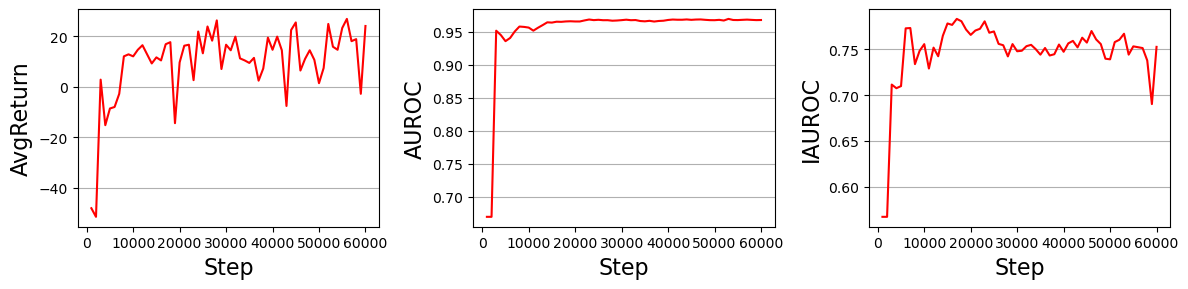

In [ ]:
torch.cuda.empty_cache()
files_dict = get_brats_files(args.data_root,10,verbose=True)
agent = DQN(args,device=device)
env = Environment(files_dict['train_normal_files'],
                    files_dict['train_target_files'],
                    files_dict['train_target_masks'],args,device)
env.update_subsamples(agent.network)
#env.initialize(agent.network)
eval_env = Environment(files_dict['train_normal_files'],
                        files_dict['train_target_files'],
                        files_dict['train_target_masks'],args,device,eval=True)
eval_env.update_subsamples(agent.network)
history = {'Step':[],'AvgReturn':[],'auroc':[],'i_auroc':[]}
s = env.reset()
best_result = 0

while True:
    action = agent.act(s)
    next_state, reward, terminated, truncated, info = env.step(agent.network,action)
    result = agent.process((s, action, reward, next_state, terminated))
    s = next_state
    if terminated or truncated:
        s = env.reset()
    if agent.total_steps % args.eval_interval == 0:
        #eval_env.copy_from_env(env)
        ret = evaluate(eval_env,agent)
        checkpoint = {
                'model': agent.network.state_dict(),
                'args': args,
                'files_dict':files_dict,
            }
        checkpoint_path = os.path.join('checkpoints/brats_10','dqn_1.pt')
        torch.save(checkpoint,checkpoint_path)
        result = evaluate_brats_metrics(checkpoint_path,device)
        cur_res = (result['auroc'] + result['i_auroc'])/2
        if cur_res >= best_result:
            best_result=cur_res
            torch.save(checkpoint,os.path.join('checkpoints/brats_10','dqn_1_best.pt'))
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        history['auroc'].append(result['auroc'])
        history['i_auroc'].append(result['i_auroc'])
        clear_output()
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))
        ax1.plot(history['Step'],history['AvgReturn'],'r-')
        ax1.set_xlabel('Step',fontsize=16)
        ax1.set_ylabel('AvgReturn', fontsize=16)
        ax1.grid(axis='y')
        ax2.plot(history['Step'],history['auroc'],'r-')
        ax2.set_xlabel('Step',fontsize=16)
        ax2.set_ylabel('AUROC', fontsize=16)
        ax2.grid(axis='y')
        ax3.plot(history['Step'],history['i_auroc'],'r-')
        ax3.set_xlabel('Step',fontsize=16)
        ax3.set_ylabel('IAUROC', fontsize=16)
        ax3.grid(axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join('checkpoints/brats_10','dqn_1.png'))
        plt.show()
    if agent.total_steps > args.max_steps:
        break

In [10]:
checkpoint_path = './checkpoints/brats_1/dqn_1_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)


torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [48:28, 33.00it/s]

auroc: 0.9430697183245743
i_auroc: 0.7439699070468389
{'auroc': 0.9430697183245743, 'i_auroc': 0.7439699070468389}


In [17]:
checkpoint_path = './checkpoints/brats_10/dqn_1_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)


torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])
auroc: 0.9682957456763799
i_auroc: 0.7804718041693628
{'auroc': 0.9682957456763799, 'i_auroc': 0.7804718041693628}


In [18]:
checkpoint_path = './checkpoints/brats_50/dqn_1_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])
auroc: 0.978877608790221
i_auroc: 0.8363262816387818
{'auroc': 0.978877608790221, 'i_auroc': 0.8363262816387818}


In [114]:
checkpoint_path = './checkpoints/brats_1_None/dqn_1_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:24:07, 19.02it/s]

auroc: 0.9508576015280942
dice: 0.11341086413858285
i_auroc: 0.8066969551001663
i_dice: 0.48991281140654797
{'auroc': 0.9508576015280942, 'dice': 0.11341086413858285, 'i_auroc': 0.8066969551001663, 'i_dice': 0.48991281140654797}


In [115]:
checkpoint_path = './checkpoints/brats_50_PER/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:04:20, 24.86it/s]

auroc: 0.980302811439375
dice: 0.5988396909905196
i_auroc: 0.8783134110511556
i_dice: 0.8431946586994326
{'auroc': 0.980302811439375, 'dice': 0.5988396909905196, 'i_auroc': 0.8783134110511556, 'i_dice': 0.8431946586994326}


In [104]:
checkpoint_path = './checkpoints/brats_10_None/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:45:08, 15.22it/s]

auroc: 0.9745508510539637
dice: 0.5324516528003758
i_auroc: 0.8732038528349987
i_dice: 0.8395738391449051
{'auroc': 0.9745508510539637, 'dice': 0.5324516528003758, 'i_auroc': 0.8732038528349987, 'i_dice': 0.8395738391449051}


In [102]:
checkpoint_path = './checkpoints/brats_10/dqn_1_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


4800it [03:01, 26.41it/s]

auroc: 0.9696870504490129
dice: 0.47273606074713703
i_auroc: 0.8096127297924436
i_dice: 0.9665008116228183
{'auroc': 0.9696870504490129, 'dice': 0.47273606074713703, 'i_auroc': 0.8096127297924436, 'i_dice': 0.9665008116228183}


In [105]:
checkpoint_path = './checkpoints/brats_10_run2/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [2:33:58, 10.39it/s]

auroc: 0.963913512973674
dice: 0.4479519649091928
i_auroc: 0.7846563525616287
i_dice: 0.9071157949180686
{'auroc': 0.963913512973674, 'dice': 0.4479519649091928, 'i_auroc': 0.7846563525616287, 'i_dice': 0.9071157949180686}


In [109]:
checkpoint_path = './checkpoints/brats_10_AP/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:33:34, 17.10it/s]

auroc: 0.9682000983143038
dice: 0.4750053997223479
i_auroc: 0.828585106025066
i_dice: 0.9258699277728147
{'auroc': 0.9682000983143038, 'dice': 0.4750053997223479, 'i_auroc': 0.828585106025066, 'i_dice': 0.9258699277728147}


In [ ]:
checkpoint_path = './checkpoints/brats_10_PER/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:27:24, 18.30it/s]

auroc: 0.9753332987494462
dice: 0.5207280421751687
i_auroc: 0.8762411571633857
i_dice: 0.8374618403510447
{'auroc': 0.9753332987494462, 'dice': 0.5207280421751687, 'i_auroc': 0.8762411571633857, 'i_dice': 0.8374618403510447}


In [110]:
checkpoint_path = './checkpoints/brats_10_PER_AP/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:32:39, 17.27it/s]

auroc: 0.9728479734841435
dice: 0.44711340839558084
i_auroc: 0.8449404475707191
i_dice: 0.8013540249855023
{'auroc': 0.9728479734841435, 'dice': 0.44711340839558084, 'i_auroc': 0.8449404475707191, 'i_dice': 0.8013540249855023}


In [111]:
checkpoint_path = './checkpoints/brats_10_PER_MB/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:46:05, 15.08it/s]

auroc: 0.9689276624737617
dice: 0.48754583529312745
i_auroc: 0.8423542406565208
i_dice: 0.8562704261654824
{'auroc': 0.9689276624737617, 'dice': 0.48754583529312745, 'i_auroc': 0.8423542406565208, 'i_dice': 0.8562704261654824}


In [112]:
checkpoint_path = './checkpoints/brats_10_AP_MB/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [2:40:03, 10.00it/s]

auroc: 0.9662527104360095
dice: 0.4459419261124598
i_auroc: 0.7775909644412835
i_dice: 0.8610898319731661
{'auroc': 0.9662527104360095, 'dice': 0.4459419261124598, 'i_auroc': 0.7775909644412835, 'i_dice': 0.8610898319731661}


In [113]:
checkpoint_path = './checkpoints/brats_10_MB/dqn_10_best.pt'
scores_dict = evaluate_brats_metrics(checkpoint_path,device)
print(scores_dict)

torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


96000it [1:31:21, 17.51it/s]

auroc: 0.9705898374203596
dice: 0.4944718861438857
i_auroc: 0.8336325238926793
i_dice: 0.9219569981370215
{'auroc': 0.9705898374203596, 'dice': 0.4944718861438857, 'i_auroc': 0.8336325238926793, 'i_dice': 0.9219569981370215}


torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])
train_normal_files: 55488
train_target_files: 10
train_target_masks: 10
val_files: 24086
val_masks: 24086
test_files: 96000
test_masks: 96000
torch.Size([1, 512, 24, 24])
torch.Size([1, 1024, 12, 12])


24096it [09:38, 41.67it/s]


1.0
0.9999994
1.0
1.0
1.0
0.9999969
1.3693763e-06
1.0


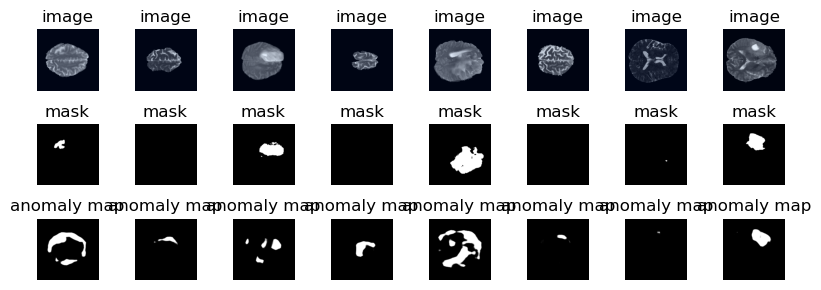

In [23]:
checkpoint_path = './checkpoints/brats_10/dqn_1.pt'
scores_dict = get_brats_scores(checkpoint_path,device)
norm_scores = (scores_dict['total_scores'] - scores_dict['total_scores'].min())/(scores_dict['total_scores'].max()-scores_dict['total_scores'].min())
visualize_result(8,scores_dict['total_imgs'],scores_dict['total_labels'],norm_scores)

0.9999947
7.443767e-05
0.99962574
1.0
1.0
1.0
0.99999964
0.6951274


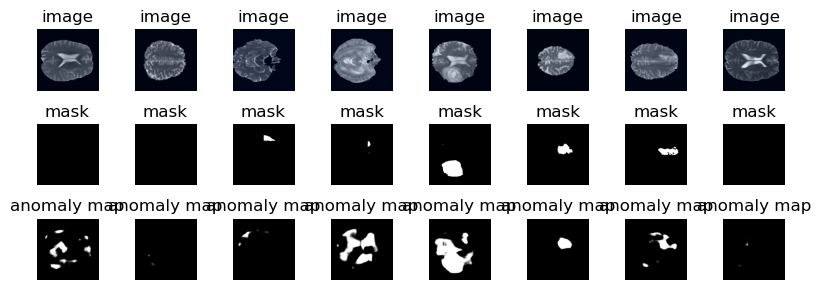

In [58]:
visualize_result(8,scores_dict['total_imgs'],scores_dict['total_labels'],norm_scores)

In [24]:
from PIL import Image
bn_scores = norm_scores >= 0.5
for i in range(len(scores_dict['total_imgs'])):
    score = Image.fromarray((norm_scores[i]*255).astype(np.uint8))
    score.save('./DQNAD/scores/'+str(i)+'.png')

    
    bn_score = Image.fromarray((bn_scores[i]*255).astype(np.uint8))
    bn_score.save('./DQNAD/bn_scores/'+str(i)+'.png')

    mask = Image.fromarray((scores_dict['total_labels'][i]*255).astype(np.uint8))
    mask.save('./DQNAD/masks/'+str(i)+'.png')


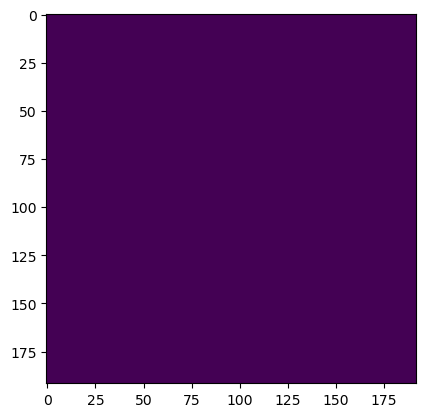

In [93]:
plt.imshow(scores_dict['total_labels'][-7])

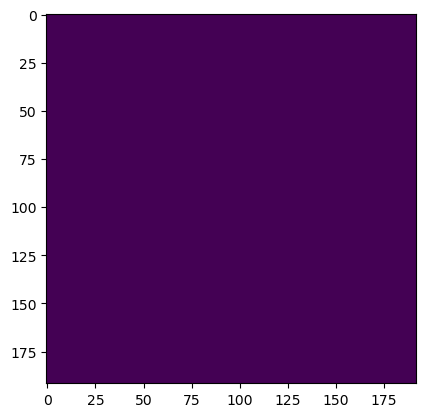

In [94]:
plt.imshow(scores_dict['total_labels'][-6])